In [6]:
# disable warning
import os; os.environ['PYGSTI_BACKCOMPAT_WARNING'] = '0'

import pygsti
import numpy as np

import matplotlib.pyplot as plt

ws = pygsti.report.Workspace()
ws.init_notebook_mode(autodisplay=True)

In [7]:
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.quantum_info.operators.channel.choi import Choi
from qiskit.tools.qi.qi import choi_to_rauli

# Asymmetric Depolarizing Channel

Empirically, noise classification was shown to perform well when 

$$
p_x + p_y + p_z \leq \sin^2(\pi / 8) \approx 0.15
$$

as seen in the `xyz_classification.ipynb` notebook.

In [8]:
def gen_error_channel(p_x, p_y, p_z, verbose=False):
    assert(p_x > 0 and p_y > 0 and p_z > 0 and p_x + p_y + p_z <= 1)
    if verbose: print("px + py + pz: ", p_x + p_y + p_z)
    return pauli_error([
    ('X', p_x),
    ('Y', p_y),
    ('Z', p_z),
    ('I', (1-p_x-p_y-p_z))
    ])

In [9]:
p_x = 0.06
p_y = 0.05
p_z = 0.04

In [10]:
error_channel = gen_error_channel(p_x, p_y, p_z, verbose=True)

def error_channel_to_choi(error_channel):
    # choi representation
    error_channel_choi = Choi(error_channel)
    # change to pauli basis
    # NOTE - choi matrix should have trace 1 ... looks like qiskit does not normalize
    error_channel_superop = choi_to_rauli(error_channel_choi.data / np.trace(error_channel_choi.data)) 
    
    # hermitian R-basis so elements should be real    
    return error_channel_superop.real

error_channel_superop = error_channel_to_choi(error_channel)

px + py + pz:  0.15


In [11]:
gi_nn = np.identity(4,'d') # 4x4 identity matrix
gx_nn = [[1, 0, 0, 0],
      [0, 1, 0, 0],
      [0, 0, 0,-1],
      [0, 0, 1, 0]] # pi/2 X-rotation in Pauli basis

gy_nn = [[1, 0, 0, 0],
      [0, 0, 0, 1],
      [0, 0, 1, 0],
      [0,-1, 0, 0]] # pi/2 Y-rotation in Pauli basis
      
def gen_error_model(error_channel_superop):
    # apply error channel

    gi = np.dot(error_channel_superop, gi_nn)
    gx = np.dot(error_channel_superop, gx_nn)
    gy = np.dot(error_channel_superop, gy_nn)

    #mdl0 = pygsti.construction.build_explicit_model((0), [(),      ('Gx',0),    ('Gy',0)], ["I(0)","X(pi/2,0)", "Y(pi/2,0)"]) 
    #print(mdl0)

    # Initialize an empty Model object
    # Designate the basis being used for the matrices and vectors below 
    # as the "Pauli product" basis of dimension 2 - i.e. the four 2x2 Pauli matrices I,X,Y,Z

    mdl = pygsti.objects.ExplicitOpModel(['Q0'],'pp') # default is pauli basis, but emphasized because modifiable 

    #Populate the Model object with states, effects, gates,
    # all in the *normalized* Pauli basis: { I/sqrt(2), X/sqrt(2), Y/sqrt(2), Z/sqrt(2) }
    # where I, X, Y, and Z are the standard Pauli matrices.

    mdl['rho0'] = [ 1/np.sqrt(2), 0, 0, 1/np.sqrt(2) ] # density matrix [[1, 0], [0, 0]] in Pauli basis
    mdl['Mdefault'] = pygsti.objects.UnconstrainedPOVM(
        {'0': [ 1/np.sqrt(2), 0, 0, 1/np.sqrt(2) ],   # projector onto [[1, 0], [0, 0]] in Pauli basis
         '1': [ 1/np.sqrt(2), 0, 0, -1/np.sqrt(2) ] }) # projector onto [[0, 0], [0, 1]] in Pauli basis

    mdl['Gi'] = gi
    mdl['Gx'] = gx

    mdl['Gy'] = gy
    return mdl

mdl = gen_error_model(error_channel_superop)
print(mdl)


rho0 = FullSPAMVec with dimension 4
 0.71   0   0 0.71


Mdefault = UnconstrainedPOVM with effect vectors:
0: FullSPAMVec with dimension 4
 0.71   0   0 0.71

1: FullSPAMVec with dimension 4
 0.71   0   0-0.71



Gi = 
FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0 0.82   0   0
   0   0 0.80   0
   0   0   0 0.78


Gx = 
FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0 0.82   0   0
   0   0   0-0.80
   0   0 0.78   0


Gy = 
FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0   0   0 0.82
   0   0 0.80   0
   0-0.78   0   0






In [12]:
from pygsti.construction import std1Q_XYI

# 1) get the target Model
mdl_ideal = std1Q_XYI.target_model()

# 2) get the building blocks needed to specify which circuits are needed
prep_fiducials, meas_fiducials = std1Q_XYI.prepStrs, std1Q_XYI.effectStrs

print("Prep Strs: ", prep_fiducials)
print("Effect Strs: ", meas_fiducials)

germs = std1Q_XYI.germs
maxLengths = [1] # roughly gives the length of the sequences used by GST

print("Germs: ", germs)

listOfExperiments = pygsti.construction.make_lsgst_experiment_list(
    mdl_ideal, prep_fiducials, meas_fiducials, germs, maxLengths)

Prep Strs:  [Circuit({}), Circuit(Gx), Circuit(Gy), Circuit(GxGx), Circuit(GxGxGx), Circuit(GyGyGy)]
Effect Strs:  [Circuit({}), Circuit(Gx), Circuit(Gy), Circuit(GxGx), Circuit(GxGxGx), Circuit(GyGyGy)]
Germs:  [Circuit(Gi), Circuit(Gx), Circuit(Gy), Circuit(GxGy), Circuit(GxGxGy), Circuit(GxGyGy), Circuit(GxGyGi), Circuit(GxGiGy), Circuit(GxGiGi), Circuit(GyGiGi), Circuit(GxGyGyGi), Circuit(GxGxGyGxGyGy)]


In [113]:
def generate_gst_data(m, nSamples):
    # add seed for deterministic
    return pygsti.construction.generate_fake_data(m, listOfExperiments, nSamples=nSamples,
                                            sampleError="binomial")
    
    # to perform GST...
    # pygsti.do_stdpractice_gst(d, mdl_ideal, prep_fiducials, meas_fiducials, 
    #                               germs, maxLengths, modes="TP,Target", verbosity=0)
    
def gen_error_data(kappa, theta, phi, nSamples):
    error_channel = gen_error_channel(kappa, theta, phi)
    error_channel_superop = error_channel_to_choi(error_channel)
    m = gen_error_model(error_channel_superop)
    return generate_gst_data(m, nSamples)

def no_noise_gst(nSamples):
    return generate_gst_data(mdl_ideal, nSamples)

In [114]:
def get_gst_features(res):
    d = []
    for idx, k in enumerate(res.keys()):
        row = res.get_row(k)
        for lbl in row.counts.keys():
            if idx % 2 == 0:
                d.append(row[lbl] / 1000.)
                
    return np.array(d)

In [115]:
err_fv_train = get_gst_features(
            gen_error_data(p_x, p_y, p_z, 1000)
            )

nn_fv_train = get_gst_features(
            no_noise_gst(1000)
            )

err_fv_test = get_gst_features(
            gen_error_data(p_x, p_y, p_z, 100)
            )

nn_fv_test = get_gst_features(
            no_noise_gst(100)
)

print("no noise: ", nn_fv_train)
print("noisy: ", err_fv_train)

no noise:  [1.    0.    0.488 0.512 0.496 0.504 0.5   0.5   0.493 0.507 0.    1.
 0.501 0.499 0.496 0.504 0.506 0.494 0.    1.    0.488 0.512 0.514 0.486
 1.    0.    0.503 0.497 0.515 0.485 0.485 0.515 0.538 0.462 1.    0.
 0.481 0.519 0.    1.    0.494 0.506 0.    1.    0.495 0.505 0.513 0.487
 0.498 0.502 0.508 0.492 0.    1.    0.546 0.454 1.    0.    0.504 0.496
 0.    1.    1.    0.    0.51  0.49  1.    0.    0.    1.    0.509 0.491
 1.    0.    0.482 0.518 0.485 0.515 0.501 0.499 0.469 0.531 0.    1.
 0.505 0.495 0.    1.    0.511 0.489 0.505 0.495]
noisy:  [1.    0.    0.471 0.529 0.516 0.484 0.524 0.476 0.48  0.52  0.206 0.794
 0.491 0.509 0.521 0.479 0.503 0.497 0.381 0.619 0.509 0.491 0.52  0.48
 0.905 0.095 0.512 0.488 0.481 0.519 0.513 0.487 0.49  0.51  0.653 0.347
 0.487 0.513 0.215 0.785 0.506 0.494 0.257 0.743 0.519 0.481 0.526 0.474
 0.497 0.503 0.514 0.486 0.416 0.584 0.494 0.506 0.654 0.346 0.499 0.501
 0.242 0.758 0.668 0.332 0.478 0.522 0.657 0.343 0.38  0.62  0.47

96


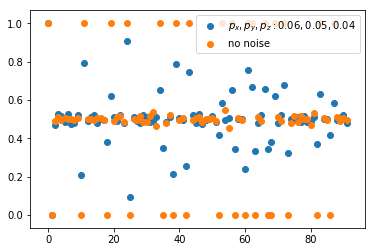

In [117]:
plt.figure()

print(len(err_fv))

plt.scatter(np.arange(92), err_fv_train, label=r"$p_x, p_y, p_z: %.2f,%.2f,%.2f$" % (p_x, p_y, p_z))
plt.scatter(np.arange(92), nn_fv_train, label="no noise")

plt.legend()

plt.show()

In [118]:
from tqdm.autonotebook import tqdm, trange # progress bar

In [119]:
class Trial:
    def __init__(self, p_x, p_y, p_z):
        self.p_x = p_x
        self.p_y = p_y
        self.p_z = p_z
        
    def __repr__(self):
        return "(p_x: %0.2f, p_y: %0.2f, p_z: %0.2f)" % (self.p_x, self.p_y, self.p_z)
    

probs = [0.04, 0.05, 0.06]
trials = []
for x in probs:
    for y in probs:
        if x == y: continue
        for z in probs:
            if z == x or z == y: continue
            trials.append(Trial(x, y, z))

assert(len(trials) == 6)
print(trials)

sample_trials = 500

[p_x: 0.04, p_y: 0.05, p_z: 0.06, p_x: 0.04, p_y: 0.06, p_z: 0.05, p_x: 0.05, p_y: 0.04, p_z: 0.06, p_x: 0.05, p_y: 0.06, p_z: 0.04, p_x: 0.06, p_y: 0.04, p_z: 0.05, p_x: 0.06, p_y: 0.05, p_z: 0.04]


In [120]:
# no noise trials

nn_fm_train = []
nn_fm_test = []

for i in trange(sample_trials):
    nn_fv_train = get_gst_features(
            no_noise_gst(1000)
            )
    nn_fv_test = get_gst_features(
            no_noise_gst(100)
            )
    
    # (px, py, pz) = (0., 0., 0.)
    nn_fv_train = np.append(nn_fv_train, (0., 0., 0.))
    nn_fv_test = np.append(nn_fv_test, (0., 0., 0.))
    # category 0 (no noise)
    nn_fv_train = np.append(nn_fv_train, 0) 
    nn_fv_test = np.append(nn_fv_test, 0) 
    
    nn_fm_train.append(nn_fv_train)
    nn_fm_test.append(nn_fv_test)

nn_fm_train = np.array(nn_fm_train)
nn_fm_test = np.array(nn_fm_test)
    

In [121]:
# noisy trials

err_fm_train = []
err_fm_test = []

# sample trials per (\kappa, \theta, \phi)
for i in trange(sample_trials):
    for t in trials:
        err_fv_train = get_gst_features(
            gen_error_data(t.p_x, t.p_y, t.p_z, 1000)
        )
        err_fv_test = get_gst_features(
            gen_error_data(t.p_x, t.p_y, t.p_z, 100)
        )

        # noise features
        err_fv_train = np.append(err_fv_train, [t.p_x, t.p_y, t.p_z])
        err_fv_test = np.append(err_fv_test, [t.p_x, t.p_y, t.p_z])

        # category 1 (noisy)
        err_fv_train = np.append(err_fv_train, 1) 
        err_fv_test = np.append(err_fv_test, 1) 

        err_fm_train.append(err_fv_train)
        err_fm_test.append(err_fv_test)

err_fm_train = np.array(err_fm_train)
err_fm_test = np.array(err_fm_test)
    

In [34]:
# overwrite value in persistent store
# WARNING: THIS WILL OVERWRITE A VARIABLE THAT IS SHARED BETWEEN NOTEBOOKS

#%store nn_fm
#%store err_fm

In [122]:
np.savetxt('asym_depolarizing-simplified/data/nn_fm_train.txt', nn_fm_train)
np.savetxt('asym_depolarizing-simplified/data/err_fm_train.txt', err_fm_train)
np.savetxt('asym_depolarizing-simplified/data/nn_fm_test.txt', nn_fm_test)
np.savetxt('asym_depolarizing-simplified/data/err_fm_test.txt', err_fm_test)

In [37]:
# reload value
#%store -r

In [135]:
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train_data = np.concatenate((err_fm_train, nn_fm_train))
test_data = np.concatenate((err_fm_test, nn_fm_test))

# only train with gst data as feature vectors
X_train = train_data[:, :92]
X_test = test_data[:, :92]
print(len(X_train[0]))

# use noise class as labelling
y_train = train_data[:, -1]
y_test = test_data[:, -1]

ss = StandardScaler()
train_data_std = ss.fit_transform(X_train)
test_data_std = ss.transform(X_test)

pca = PCA(2)
train_data_trans = pca.fit_transform(train_data_std)
test_data_trans = pca.transform(test_data_std)

print("Explained variance: ", pca.explained_variance_ratio_)
print("Singular values: ", pca.singular_values_)

92
Explained variance:  [0.32569886 0.02616838]
Singular values:  [320.30476245  90.79118091]


In [148]:
def get_err_fm(comps:int):
    # only train with gst data as feature vectors
    train_X_e = err_fm_train[:, :92]
    test_X_e = err_fm_test[:, :92]

    ss = StandardScaler()
    train_err_fm_std = ss.fit_transform(train_X_e)
    test_err_fm_std = ss.transform(test_X_e)

    pca = PCA(comps)
    train_err_fm_trans = pca.fit_transform(train_err_fm_std)
    test_err_fm_trans = pca.transform(test_err_fm_std)

    print("Explained variance: ", pca.explained_variance_ratio_)
    print("tot explained: ", np.sum(pca.explained_variance_ratio_))
    print("Singular values: ", pca.singular_values_)
    
    return train_err_fm_trans, test_err_fm_trans

In [164]:
def create_mesh(data_trans):
    # grid for plotting decision bdry

    x_min = np.min(data_trans[:,0])
    x_max = np.max(data_trans[:, 0])
    y_min = np.min(data_trans[:, 1])
    y_max = np.max(data_trans[:, 1])
    h = .02  # step size in the mesh

    cm = plt.cm.RdBu

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    return grid, xx

def get_contour_map(clf, data_trans):
    grid, xx = create_mesh(data_trans)
    Z = clf.predict(grid) 
    return Z.reshape(xx.shape)

# SVM Classification

In [166]:
# RBF kernel
clf = svm.SVC(kernel='rbf', gamma='auto')

def fit_and_score_svm(clf, data, lbl, test_data, test_lbl, contour=False):
    clf.fit(data, lbl)
    train_acc = clf.score(data, lbl)
    print("train acc: ", train_acc)
    test_acc = clf.score(test_data, test_lbl)
    print("test acc: ", test_acc)
    # contour to plot decision boundary
    Z_train = Z_test = None
    if contour:
        Z_train = get_contour_map(clf, data)
        Z_test = get_contour_map(clf, test_data)
    return train_acc, test_acc, Z_train, Z_test


In [161]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [162]:
def get_err_fm_labels(err_fm):
    lbl = []
    for i in trange(len(err_fm)):
        ordering = 0

        x_i = err_fm[i, -4]
        y_i = err_fm[i, -3]
        z_i = err_fm[i, -2]

        if x_i > y_i and y_i > z_i:
            ordering = 1

        if x_i > z_i and z_i > y_i:
            ordering = 2

        if y_i > z_i and z_i > x_i:
            ordering = 3

        if y_i > x_i and x_i > z_i:
            ordering = 4

        if z_i > x_i and x_i > y_i:
            ordering = 5

        # last case -- ordering=0

        lbl.append(ordering)
    return lbl


train_lbl = get_err_fm_labels(err_fm_train)
test_lbl = get_err_fm_labels(err_fm_test)

train_lbl = np.array(train_lbl)
test_lbl = np.array(test_lbl)

In [165]:
train_acc, test_acc, Z_train, Z_test = fit_and_score_svm(clf, train_data_trans, y_train, test_data_trans, y_test, contour=True)

train acc:  1.0
test acc:  0.8571428571428571


In [ ]:
train_err_fm_trans, test_err_fm_trans = get_err_fm(2)
train_acc_ord, test_acc_ord, Z_ord_train, Z_ord_test = fit_and_score_svm(
    clf, train_err_fm_trans, train_lbl, test_err_fm_trans, test_lbl, contour=True
    )

Explained variance:  [0.07940986 0.03753492]
tot explained:  0.11694477935170529
Singular values:  [146.42630463 100.66989489]
train acc:  0.72
test acc:  0.16666666666666666


In [154]:
for pca_comps in trange(5, 40, 5):
    print("num PCs: ", pca_comps)
    train_err_fm_trans, test_err_fm_trans = get_err_fm(pca_comps)
    fit_and_score_svm(clf, train_err_fm_trans, train_lbl, test_err_fm_trans, test_lbl, contour=False)
    print("\n")

Explained variance:  [0.07940986 0.03753016]
tot explained:  0.11694002490362482
Singular values:  [146.42630451 100.66351907]
train acc:  0.7206666666666667
test acc:  0.16666666666666666


num PCs:  5
Explained variance:  [0.07940986 0.03754271 0.02625011 0.02595666 0.02521258]
tot explained:  0.19437191888483676
Singular values:  [146.42630444 100.68034009  84.18747231  83.71558107  82.50694261]
train acc:  0.7773333333333333
test acc:  0.16666666666666666


num PCs:  10
Explained variance:  [0.07940974 0.03749987 0.0263316  0.02601281 0.02536214 0.02486964
 0.02426178 0.02413058 0.02387093 0.02354296]
tot explained:  0.3152920272418314
Singular values:  [146.42618864 100.62287789  84.31803453  83.80607658  82.7512969
  81.94389912  80.93626968  80.71713436  80.2816928   79.72828979]
train acc:  0.876
test acc:  0.16666666666666666


num PCs:  15
Explained variance:  [0.07940959 0.03734944 0.02650586 0.02599184 0.02518616 0.02504145
 0.02469528 0.02436239 0.02365349 0.02362196 0.02344736 0.02305612
 0.02287754 0.02263416 0.02224687]
tot explained:  0.4300795107511393
Singular values:  [146.42605086 100.4208638   84.59658173  83.77229432  82.46370882
  82.22646932  81.65

In [155]:
class Scatter:
    def __init__(self, data: list, label: str):
        self.data = data
        self.label = label

class Contour:
    def __init__(self, Z, color_map):
        self.Z = Z
        self.color_map = color_map
    
class Plot:
    def __init__(self, scatters: list, contour: Contour, title: str):
        self.scatters = scatters
        self.contour = contour
        self.title = title
    
def show_plots(plots, contour=False):
    plt.figure(figsize=(20, 40))
    
    for idx, plot in enumerate(plots):
        plt.subplot(len(plots), 1, idx + 1)
        
        for s in plot.scatters:
            plt.scatter(s.data[:, 0], s.data[:, 1], label=s.label, edgecolors='k')
            
        if contour: plt.contourf(xx, yy, plot.contour.Z, alpha=.5, cmap = plot.contour.color_map)
            
        plt.legend()
        plt.title(plot.title)

    plt.show()

In [168]:
orderings = [0, 1, 2, 3, 4, 5]

plot_data = [
    Plot(
        [
            Scatter(train_data_trans[y_train == 0], 'Noisy'),
            Scatter(train_data_trans[y_train == 1], 'No noise')
        ],
        Contour(Z_train, cm),
        "Train Noise (acc: %f)" % train_acc
        
    ),
    Plot(
        [
            Scatter(test_data_trans[y_test == 0], 'Noisy'),
            Scatter(test_data_trans[y_test == 1], 'No noise')
        ],
        Contour(Z_test, cm),
        "Test Noise (acc: %f)" % test_acc
        
    ),
    Plot(
        [
            Scatter(train_err_fm_trans[train_lbl == o], str(o)) for o in orderings
        ],
        Contour(Z_ord_train, 'Pastel1'),
        r"Train Channel classes (acc: %f)" % train_acc_ord
        
    ),
    Plot(
        [
            Scatter(test_err_fm_trans[test_lbl == o], str(o)) for o in orderings
        ],
        Contour(Z_ord_test, 'Pastel1'),
        r"Test Channel classes (acc: %f)" % test_acc_ord
        
    )
]

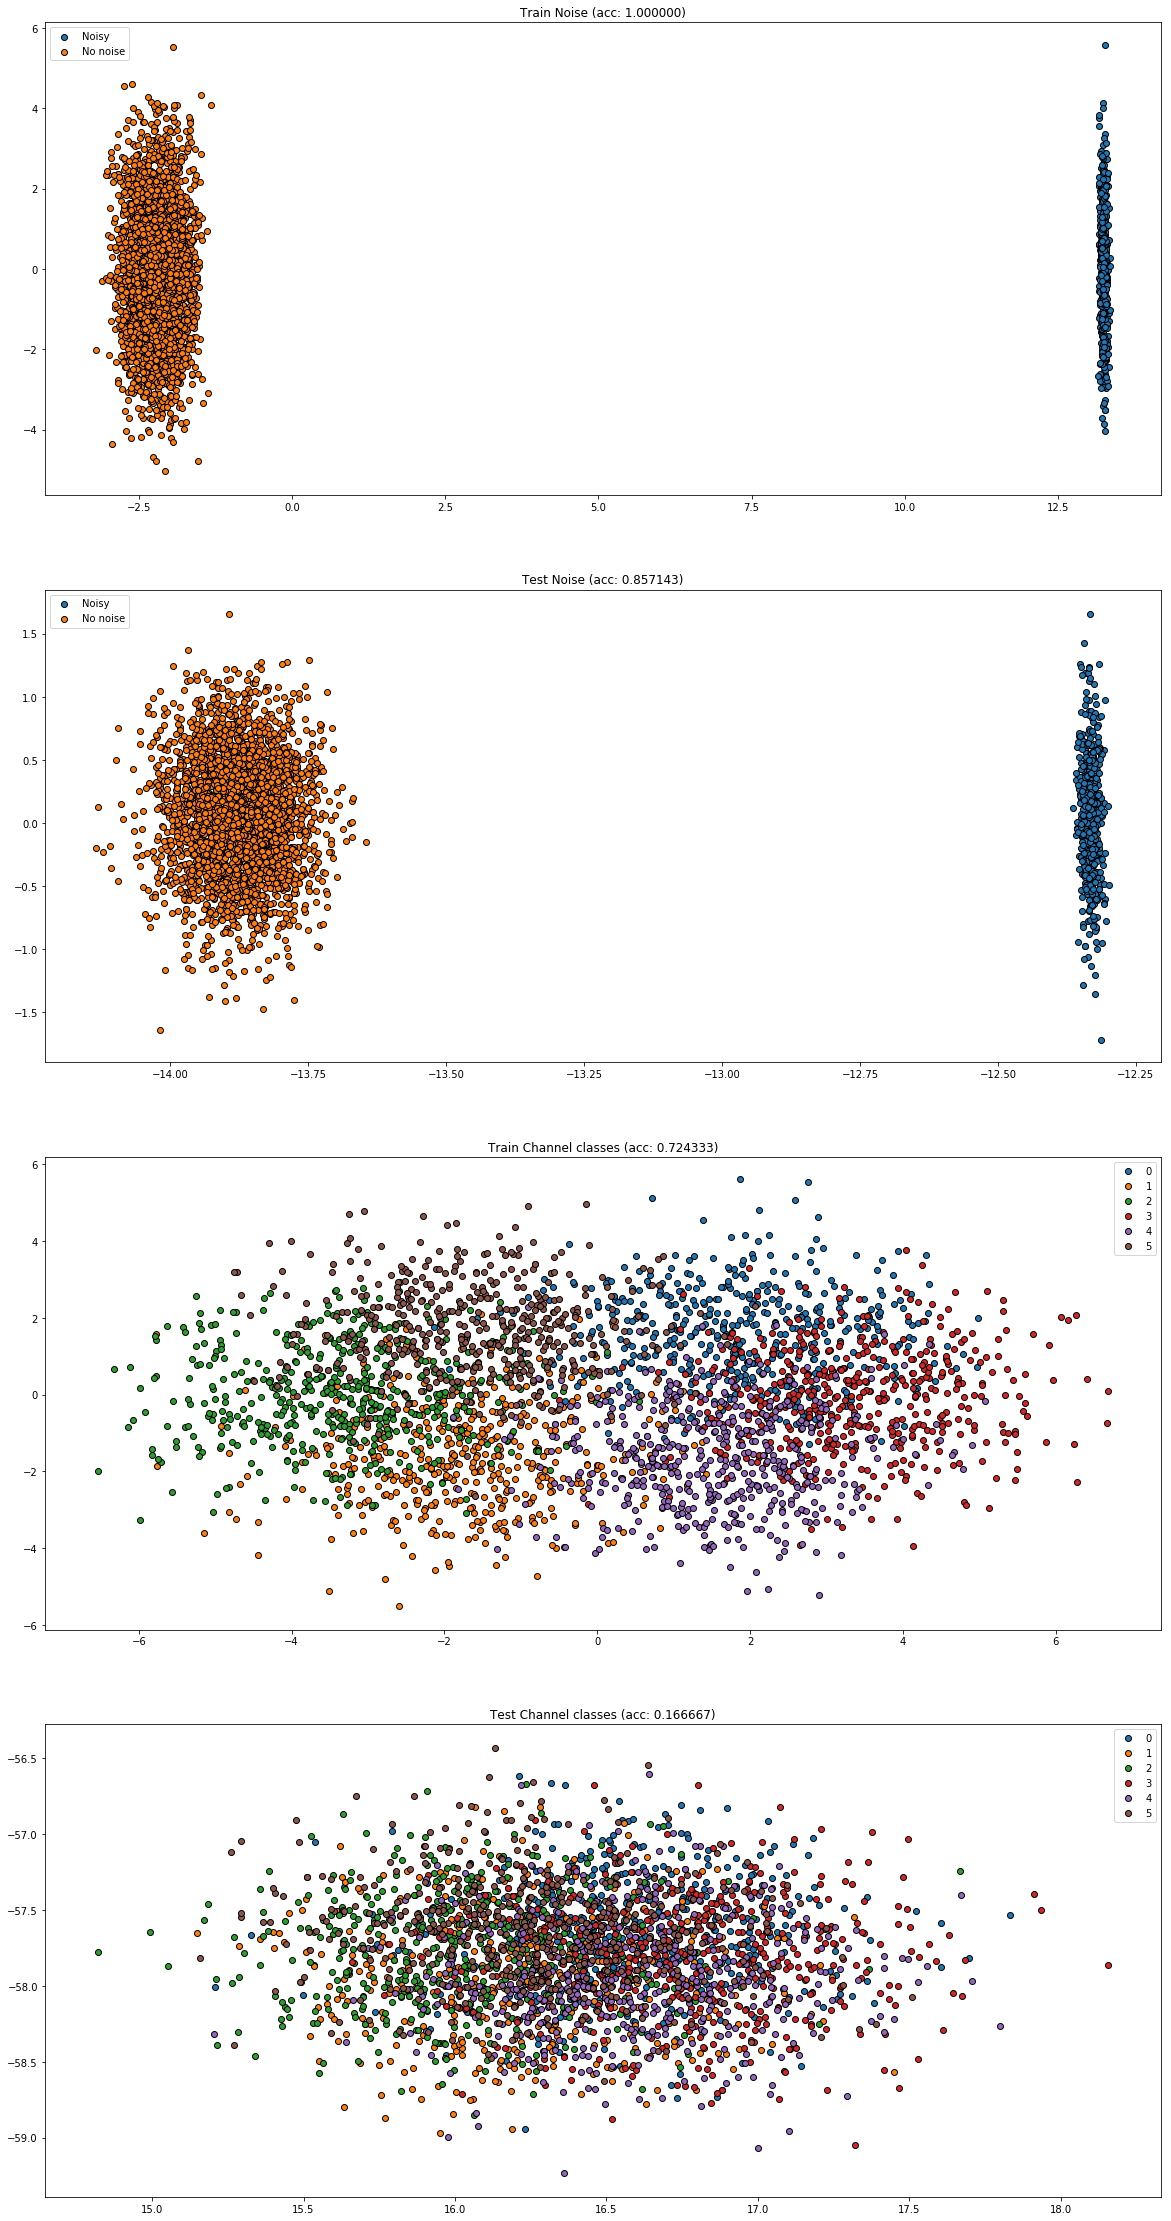

In [169]:
show_plots(plot_data)

TypeError: Shape of x does not match that of z: found (493, 825) instead of (530, 828).

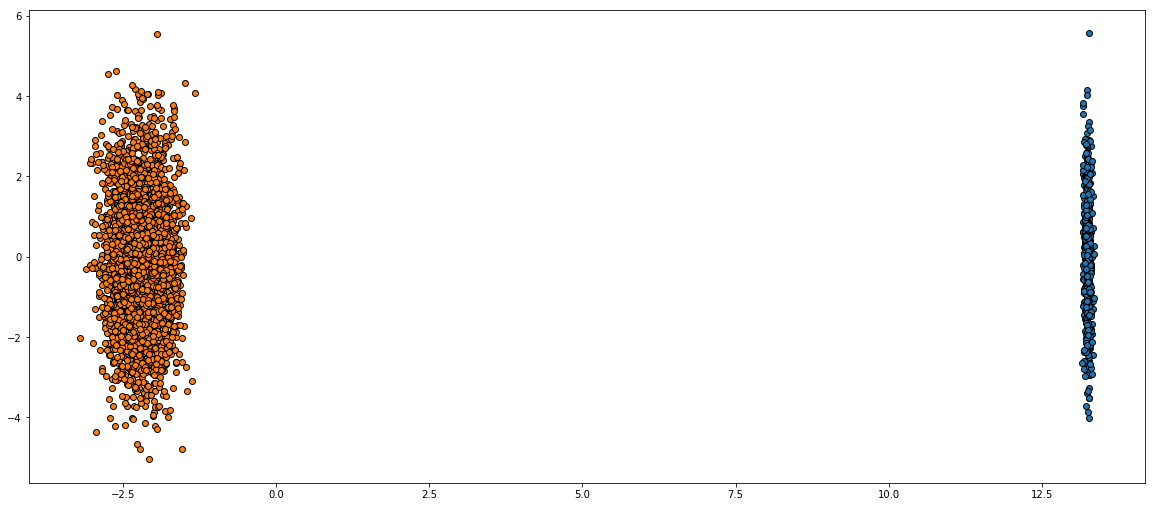

In [170]:
show_plots(plot_data, True)

SVM does not perform exceptionally well, but there is clearly a nice structure to the data especially in the $\sigma_x, \sigma_y$ case. We still see substantial improvement over random guessing which would classify correctly w.p. $\approx 0.11$. We can expect to perform much better if the spacing is increased between probability classes. **In any event, this problem is better posed as a regression one because misclassifications are likely often to an adjacent class.**

# NN Classification -- 92 Dimensions

In [6]:
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split

device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [186]:
def nn_train_model(data, labels, steps, num_classes):
    
    dt_train, lt_train = \
        torch.from_numpy(data).float().to(device=device), \
        torch.from_numpy(labels).to(device=device)

    num_inputs = len(data[0])
    H = max(num_inputs, num_classes)
    
    # N is batch size; D_in is input dimension;
    # H is hidden dimension; D_out is output dimension.
    N, D_in, H1, H2, D_out = 64, num_inputs, H, H, num_classes

    # Use the nn package to define our model as a sequence of layers
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H1),
        torch.nn.ReLU(),
        torch.nn.Linear(H1, H2),
        torch.nn.ReLU(),
        torch.nn.Linear(H2, D_out),
    ).to(device=device)

    # stochastic gradient descent w/ hessian
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # ll loss for classification
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-4
    with trange(steps) as tr:
        for t in tr:
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(dt_train)

            # Compute and print loss
            loss = loss_fn(y_pred, lt_train)
            tr.set_description("Loss: %f" % loss.item())

            # Zero the gradients before running the backward pass.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to all the learnable
            # parameters of the model.
            loss.backward()
            # Step
            optimizer.step()
            
    return model
    

In [139]:
from sklearn.metrics import accuracy_score

def get_preds(model, data):
    o = model(data)
    _, pred = torch.max(o, 1)
    return pred

In [163]:
def nn_get_contour_map(model):
    preds = get_preds(model, torch.from_numpy(grid).float().to(device=device))
    return preds.reshape(xx.shape)

In [184]:
def train_and_test(data, labels, num_classes, steps, contour=False):
    dt_train, dt_test, lt_train, lt_test = train_test_split(
        data, labels, test_size=0.2, random_state=42) # seed
    
    model = nn_train_model(dt_train, lt_train, steps=steps, num_classes=num_classes)
    
    tr_preds = get_preds(model, torch.from_numpy(dt_train).float().to(device=device))
    ts_preds = get_preds(model, torch.from_numpy(dt_test).float().to(device=device))
    
    print("training accuracy: ", accuracy_score(tr_preds.cpu(), lt_train))
    print("test accuracy: ", accuracy_score(ts_preds.cpu(), lt_test))
    
    return nn_get_contour_map(model).cpu() if contour else None
    
    

In [151]:
train_and_test(data_std, px_labels, num_classes=tg.px.size, steps=5000)

training accuracy:  0.7912671232876712
test accuracy:  0.7267123287671233


In [76]:
train_and_test(data_std, py_labels, num_classes=tg.py.size, steps=5000)

training accuracy:  0.7308219178082191
test accuracy:  0.6568493150684932


In [77]:
train_and_test(data_std, pz_labels, num_classes=tg.pz.size, steps=5000)

training accuracy:  0.536986301369863
test accuracy:  0.48561643835616436


The neural network performs well and even seems to generalize. This is particularly impressive noting how small the spacing is between each probability class! Do note that we are considering all 92 dimensions in this case, however. Hence, we better try with only the two PCA dimensions to properly compare. We can then plot the contours in the 2D projection plane similarly to before.

# NN Classification -- 2 PCA Dimensions

In [187]:
nn_Z_px = train_and_test(data_trans, px_labels, num_classes=tg.px.size, steps=5000, contour=True)

training accuracy:  0.4613013698630137
test accuracy:  0.45136986301369864


In [188]:
nn_Z_py = train_and_test(data_trans, py_labels, num_classes=tg.py.size, steps=5000, contour=True)

training accuracy:  0.3333904109589041
test accuracy:  0.3404109589041096


In [ ]:
nn_Z_pz = train_and_test(data_trans, pz_labels, num_classes=tg.pz.size, steps=5000, contour=True)

In [190]:
nn_plot_data = [
    Plot(
        [
            Scatter(data_trans[y_px == p], str(p)) for p in tg.px.trials
        ],
        Contour(nn_Z_px, 'Pastel1'),
        r"Varying $p_x$ (acc: %f)" % acc_px
        
    ),
    Plot(
        [
            Scatter(data_trans[y_py == p], str(p)) for p in tg.py.trials
        ],
        Contour(nn_Z_py, 'Pastel1'),
        r"Varying $p_y$ (acc: %f)" % acc_py
        
    ),
    Plot(
        [
            Scatter(data_trans[y_pz == p], str(p)) for p in tg.pz.trials
        ],
        Contour(nn_Z_pz, 'Pastel1'),
        r"Varying $p_z$ (acc: %f)" % acc_pz,
    )
]

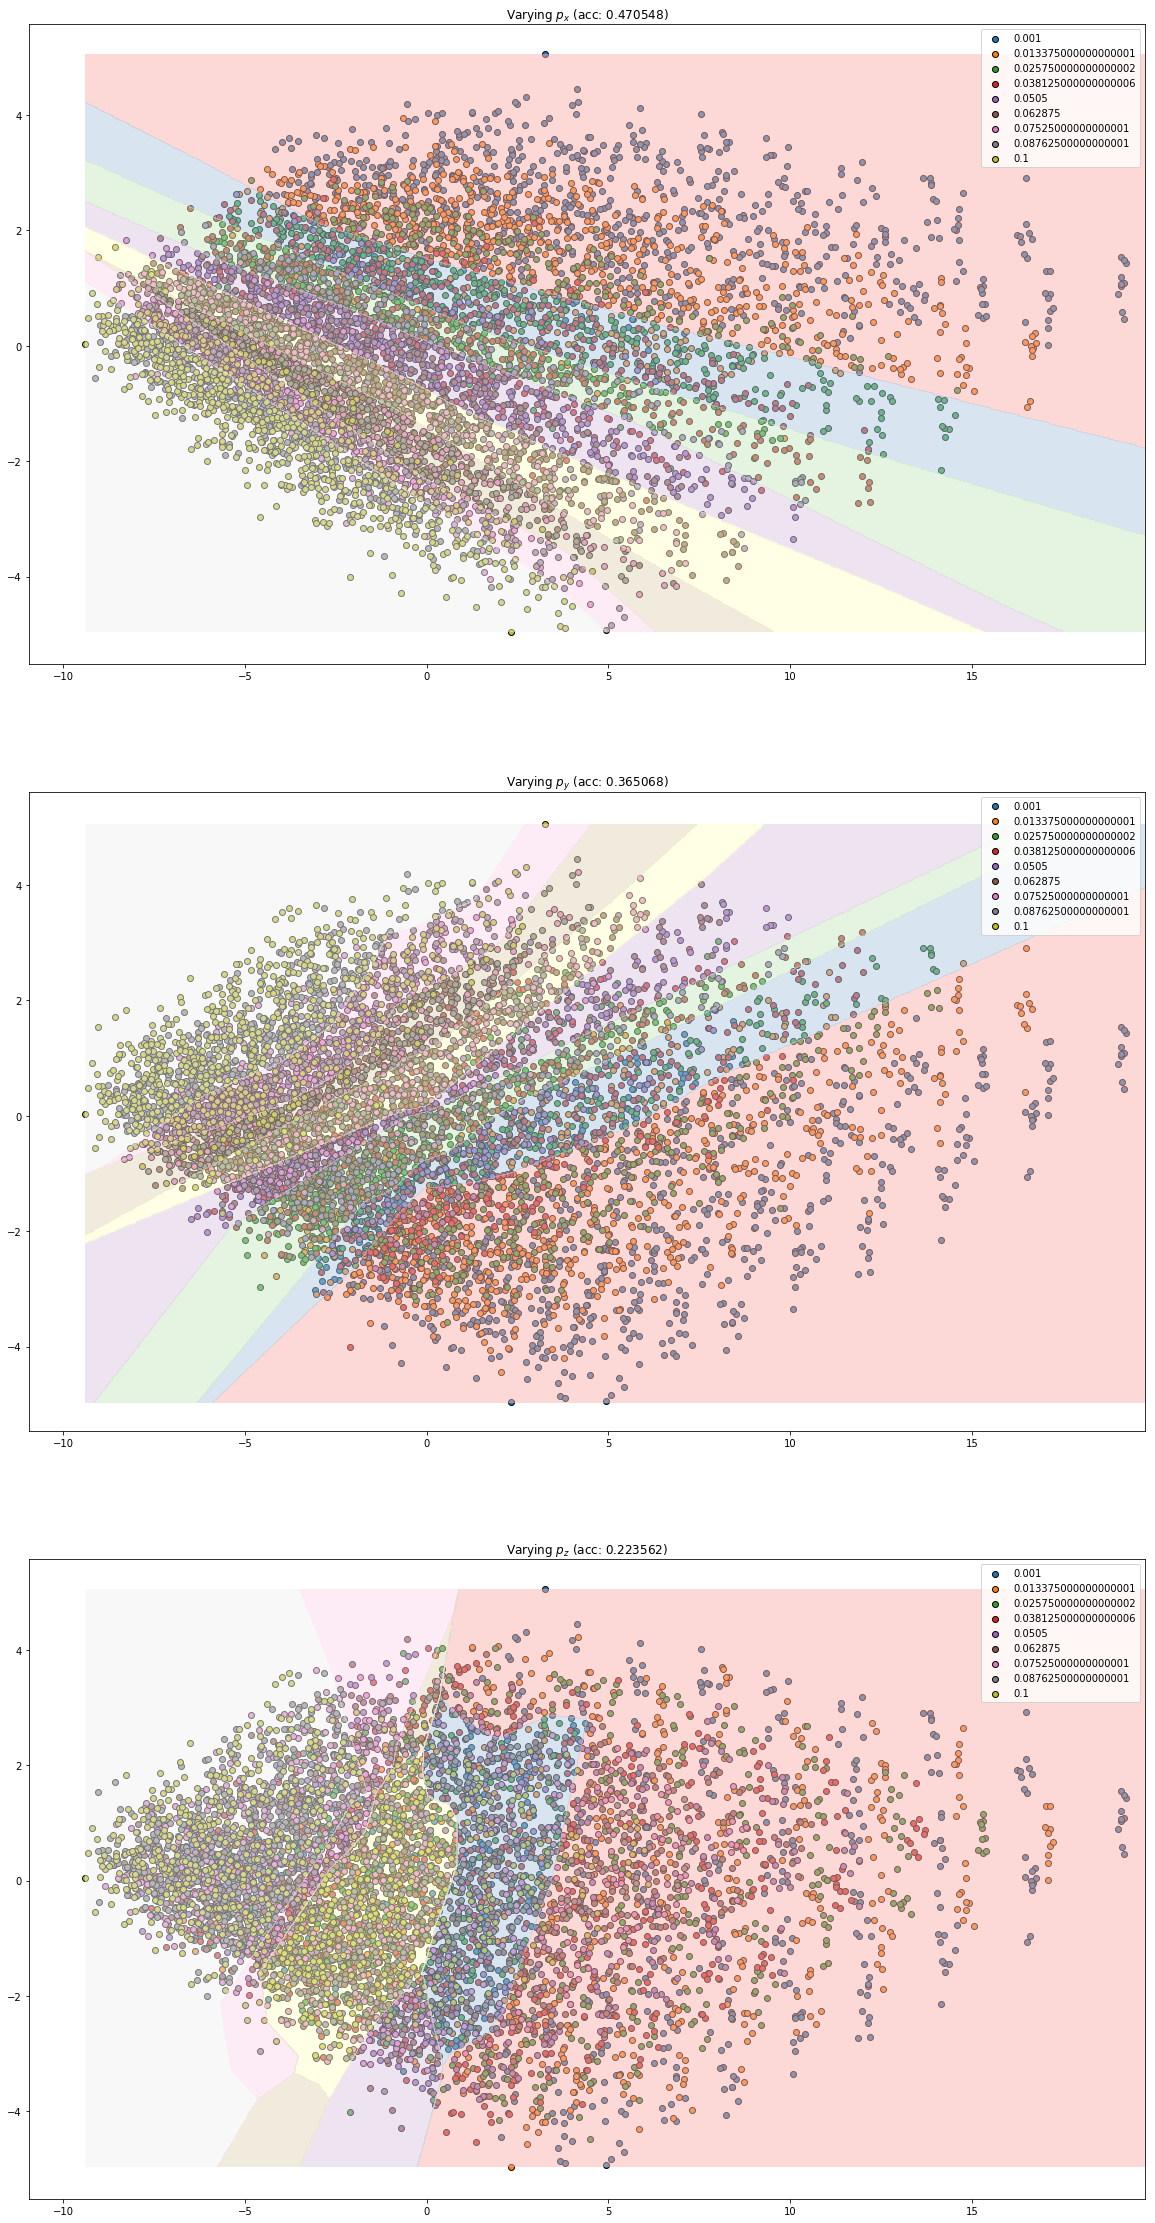

In [191]:
show_plots(nn_plot_data, True)

# NN Regression

Let us reformulate in terms of a more suitable regression problem...

We will us quantum relative entropy as our loss function. In the ML community, they call this method of comparing probability distributions "Kullback–Leibler divergence". In particular, each feature corresponds to a distribution $(1-p_{total}, p_x, p_y, p_z)$. Let our neural network perform softmax (actually log softmax to work with log probabilities for better numerical performance) at the last layer of four neurons so that we can interpet the output as a distribution. For example, data vector $\vec{x}$ may give probabilities $\hat{y} = (\hat{y}_1, \hat{y}_2, \hat{y}_3, \hat{y}_4$ with true values $y = (y_1, y_2, y_3, y_4)$. Our loss function on a single feature vector gives

$$
l(y \mid\mid \hat{y}) = y \log(y / \hat{y})
$$

Hence, on a batch we are comparing the distributions by $H(Y , \hat{Y}) - H(Y)$ (note: asymmetric) where $H(\cdot, \cdot)$ is the cross-entropy.


In [7]:
def nn_regress(data, labels, test_data, test_labels, steps):
    
    dt_train, lt_train = \
        torch.from_numpy(data).float().to(device=device), \
        torch.from_numpy(labels).float().to(device=device)

    H = num_inputs = len(data[0])
    
    # N is batch size; D_in is input dimension;
    # H is hidden dimension; D_out is output dimension.
    N, D_in, H1, H2, D_out = 64, num_inputs, H, H, 4

    # Use the nn package to define our model as a sequence of layers
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H1),
        torch.nn.ReLU(),
        torch.nn.Linear(H1, H2),
        torch.nn.ReLU(),
        torch.nn.Linear(H2, D_out),
        torch.nn.LogSoftmax()
    ).to(device=device)

    # stochastic gradient descent w/ hessian
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # ll loss for classification
    loss_fn = torch.nn.KLDivLoss()

    learning_rate = 1e-4
    with trange(steps) as tr:
        for t in tr:
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(dt_train)

            # Compute and print loss
            loss = loss_fn(y_pred, lt_train)
            tr.set_description("Loss: %f" % loss.item())
            
            if t % 10000 == 0:
                print("iteration %i, evaluating test accuracy" % t)
                accuracy_score_reg(
                        model, test_data, test_labels
                        )

            # Zero the gradients before running the backward pass.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to all the learnable
            # parameters of the model.
            loss.backward()
            # Step
            optimizer.step()
            
    return model
    

In [8]:
thresh = 0.1

def accuracy_score_reg(model, data_x, data_y):
    X = torch.from_numpy(data_x).float().to(device=device)
    Y = torch.from_numpy(data_y).float().to(device=device)
    n_items = len(X)
    oupt = torch.exp(model(X))
    
    loss_fn = torch.nn.L1Loss(reduction="none")
    loss = torch.sum(loss_fn(Y, oupt), 1)
    
    print("mean loss (L1): ", torch.mean(loss).item())
    n_correct = torch.sum( loss < thresh)
    result = (n_correct.item() / n_items)  # scalar
    print("accuracy: ", result)
    
    return oupt

In [9]:
def train_and_test_regress(data, labels, steps):
    dt_train, dt_test, lt_train, lt_test = train_test_split(
        data, labels, test_size=0.2, random_state=42) # seed
    
    model = nn_regress(dt_train, lt_train, dt_test, lt_test, steps=steps)
    
    
    
    print("training")
    print("accuracy threshold (L1): ", thresh)
    tr_preds = accuracy_score_reg(
            model, dt_train, lt_train
            )
    
    print("test")
    ts_preds = accuracy_score_reg(
            model, dt_test, lt_test
            )
    
    return tr_preds.cpu(), ts_preds.cpu(), lt_train, lt_test
    
    

In [10]:
y_reg = data[:, -4:-1]
#f = lambda x, y: x * y
#f_arr = np.frompyfunc(f, 2, 1)
#vf = np.vectorize(f)

def complement(x):
    return 1 - x[0] - x[1] - x[2]

feat_4 = np.apply_along_axis(complement, 1, y_reg)

y_reg = np.vstack( (y_reg.T, feat_4 )).T

print(y_reg)

[[0.001    0.001    0.001    0.997   ]
 [0.001    0.001    0.013375 0.984625]
 [0.001    0.001    0.02575  0.97225 ]
 ...
 [0.       0.       0.       1.      ]
 [0.       0.       0.       1.      ]
 [0.       0.       0.       1.      ]]


In [12]:
tr_preds, ts_preds, lt_train, lt_test = train_and_test_regress(data_std, y_reg, steps=500000)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1992: UserWarning:

reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.



iteration 0, evaluating test accuracy
mean loss (L1):  1.1747276782989502
accuracy:  0.0
iteration 10000, evaluating test accuracy
mean loss (L1):  0.08889342099428177
accuracy:  0.636986301369863
iteration 20000, evaluating test accuracy
mean loss (L1):  0.0771336555480957
accuracy:  0.7643835616438356
iteration 30000, evaluating test accuracy
mean loss (L1):  0.06662515550851822
accuracy:  0.8602739726027397
iteration 40000, evaluating test accuracy
mean loss (L1):  0.06002265214920044
accuracy:  0.9075342465753424
iteration 50000, evaluating test accuracy
mean loss (L1):  0.05499320104718208
accuracy:  0.936986301369863
iteration 60000, evaluating test accuracy
mean loss (L1):  0.04991375654935837
accuracy:  0.9582191780821918
iteration 70000, evaluating test accuracy
mean loss (L1):  0.04538226127624512
accuracy:  0.9732876712328767
iteration 80000, evaluating test accuracy
mean loss (L1):  0.042426932603120804
accuracy:  0.9794520547945206
iteration 90000, evaluating test accuracy

In [13]:
%store tr_preds
%store ts_preds
%store lt_train
%store lt_test

Stored 'tr_preds' (Tensor)
Stored 'ts_preds' (Tensor)
Stored 'lt_train' (ndarray)
Stored 'lt_test' (ndarray)


In [7]:
tr_preds = tr_preds.detach().numpy()
ts_preds = ts_preds.detach().numpy()

In [15]:
np.savetxt('asym_depolarizing/data/nn/regression/tr_preds.txt', tr_preds)
np.savetxt('asym_depolarizing/data/nn/regression/ts_preds.txt', ts_preds)
np.savetxt('asym_depolarizing/data/nn/regression/lt_train.txt', lt_train)
np.savetxt('asym_depolarizing/data/nn/regression/lt_test.txt', lt_test)

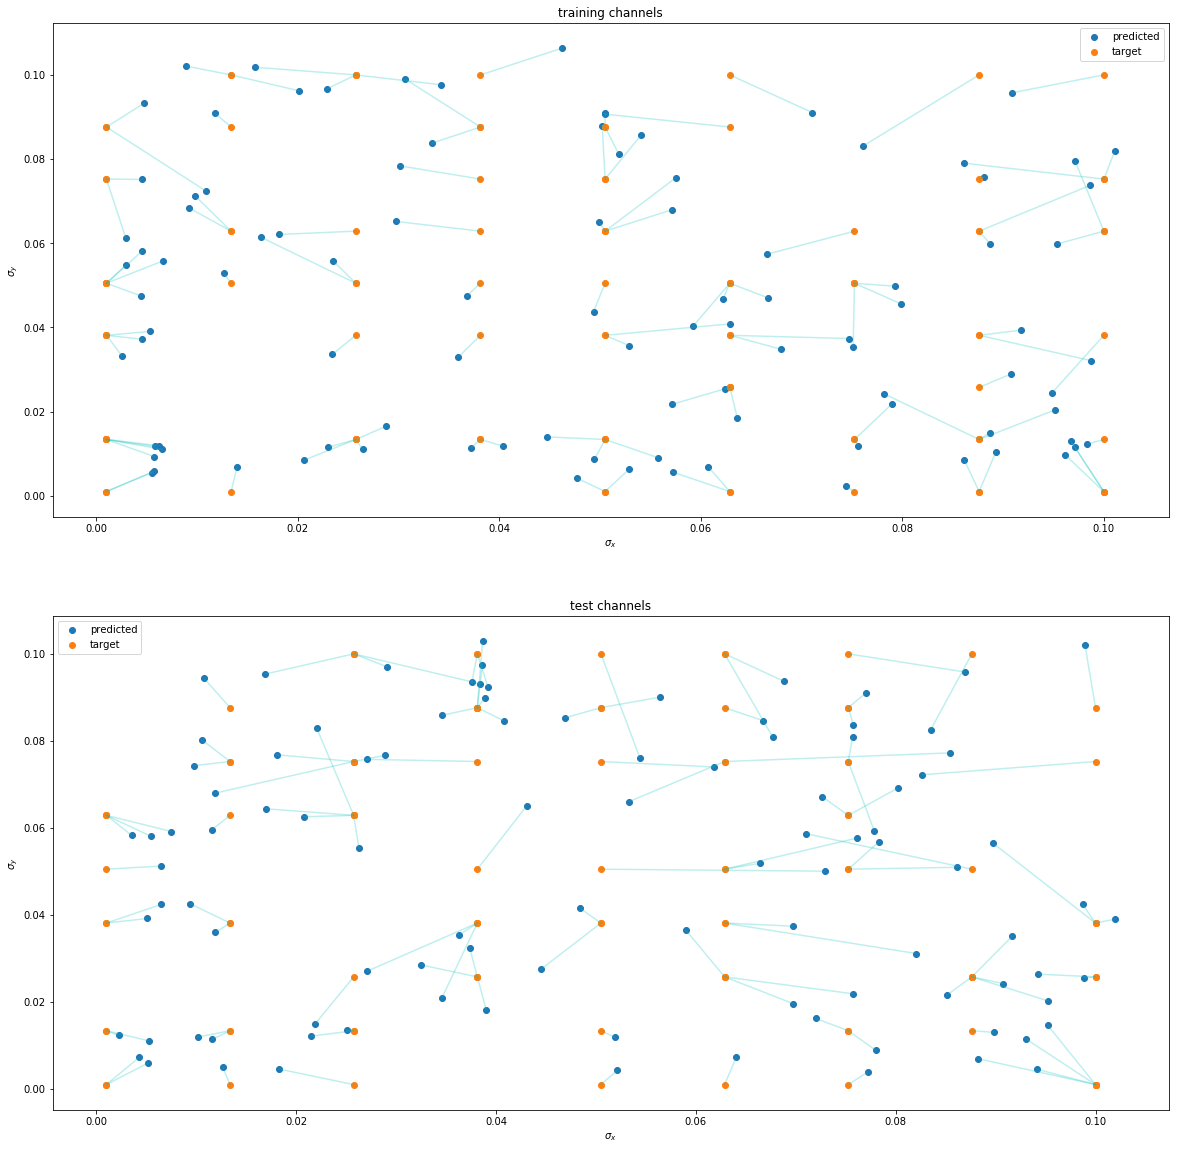

In [47]:
from sklearn.utils.random import sample_without_replacement
%matplotlib inline

plt.rcParams["figure.figsize"] = (20, 20)
plt.figure()

plt.subplot(2, 1, 1)

plt.title("training channels")

idx = sample_without_replacement(len(tr_preds), 100)

for i in idx:
    plt.plot((tr_preds[:, 0][i], lt_train[:, 0][i]), (tr_preds[:, 1][i], lt_train[:, 1][i]), c='c', alpha=0.25)
    
plt.scatter(tr_preds[:, 0][idx], tr_preds[:, 1][idx], label='predicted')
plt.scatter(lt_train[:, 0][idx], lt_train[:, 1][idx], label='target')

plt.legend()

plt.xlabel(r"$\sigma_x$")
plt.ylabel(r"$\sigma_y$")

plt.subplot(2, 1, 2)

plt.title("test channels")

idx = sample_without_replacement(len(ts_preds), 100)

for i in idx:
    plt.plot((ts_preds[:, 0][i], lt_test[:, 0][i]), (ts_preds[:, 1][i], lt_test[:, 1][i]), c='c', alpha=0.25)
    
plt.scatter(ts_preds[:, 0][idx], ts_preds[:, 1][idx], label='predicted')
plt.scatter(lt_test[:, 0][idx], lt_test[:, 1][idx], label='target')

plt.legend()

plt.xlabel(r"$\sigma_x$")
plt.ylabel(r"$\sigma_y$")

plt.show()

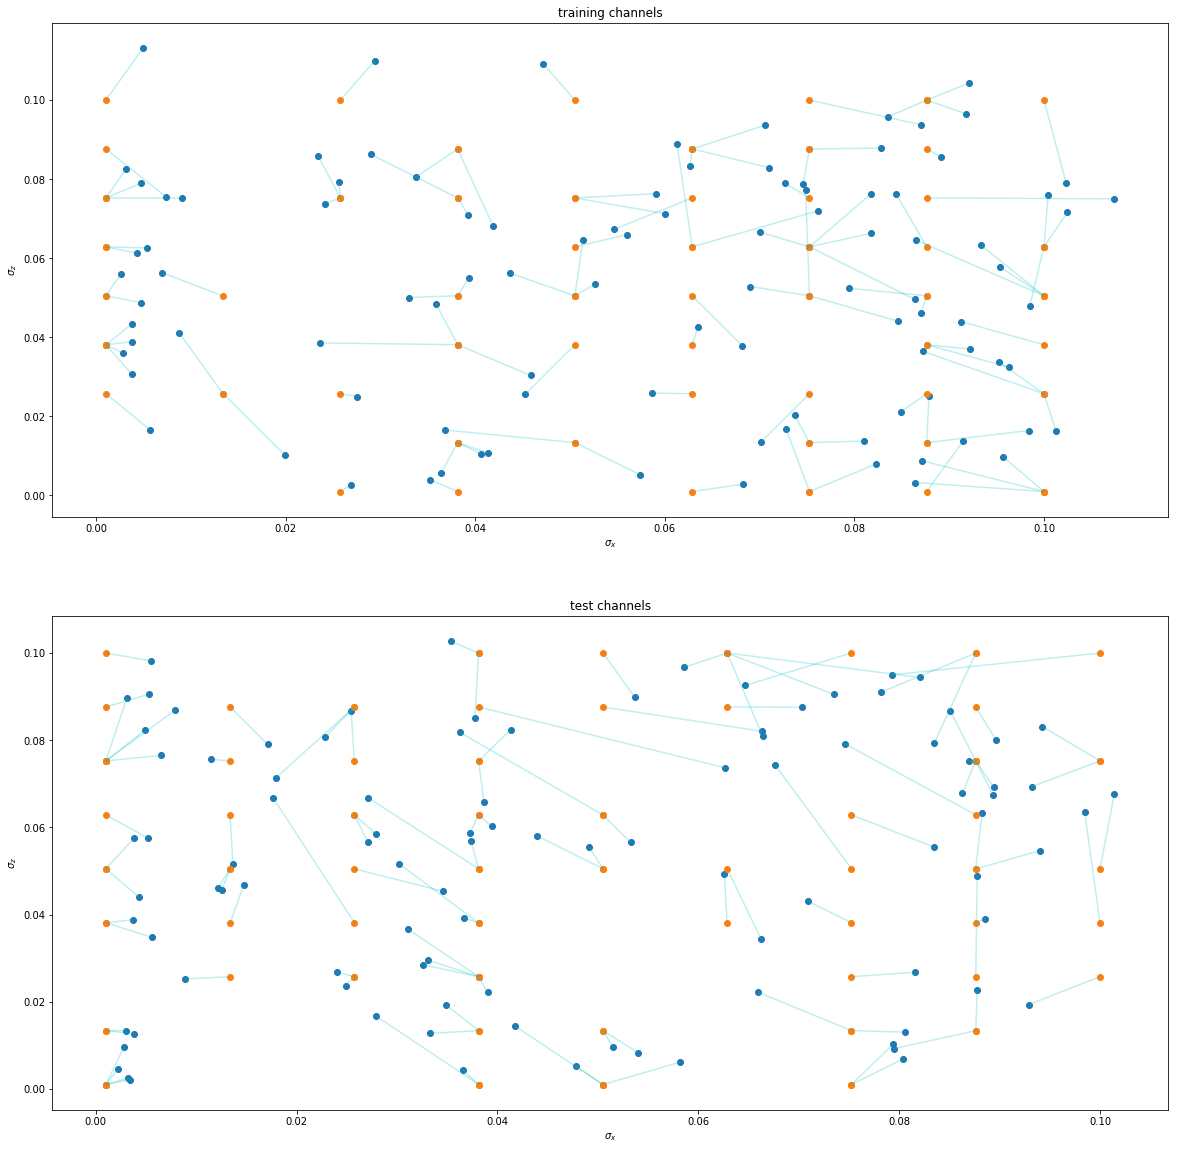

In [45]:
from sklearn.utils.random import sample_without_replacement
%matplotlib inline

plt.rcParams["figure.figsize"] = (20, 20)
plt.figure()

plt.subplot(2, 1, 1)

plt.title("training channels")

idx = sample_without_replacement(len(tr_preds), 100)

for i in idx:
    plt.plot((tr_preds[:, 0][i], lt_train[:, 0][i]), (tr_preds[:, 2][i], lt_train[:, 2][i]), c='c', alpha=0.25)
    
plt.scatter(tr_preds[:, 0][idx], tr_preds[:, 2][idx])
plt.scatter(lt_train[:, 0][idx], lt_train[:, 2][idx])

plt.xlabel(r"$\sigma_x$")
plt.ylabel(r"$\sigma_z$")

plt.subplot(2, 1, 2)

plt.title("test channels")

idx = sample_without_replacement(len(ts_preds), 100)

for i in idx:
    plt.plot((ts_preds[:, 0][i], lt_test[:, 0][i]), (ts_preds[:, 2][i], lt_test[:, 2][i]), c='c', alpha=0.25)
    
plt.scatter(ts_preds[:, 0][idx], ts_preds[:, 2][idx])
plt.scatter(lt_test[:, 0][idx], lt_test[:, 2][idx])

plt.xlabel(r"$\sigma_x$")
plt.ylabel(r"$\sigma_z$")

plt.show()

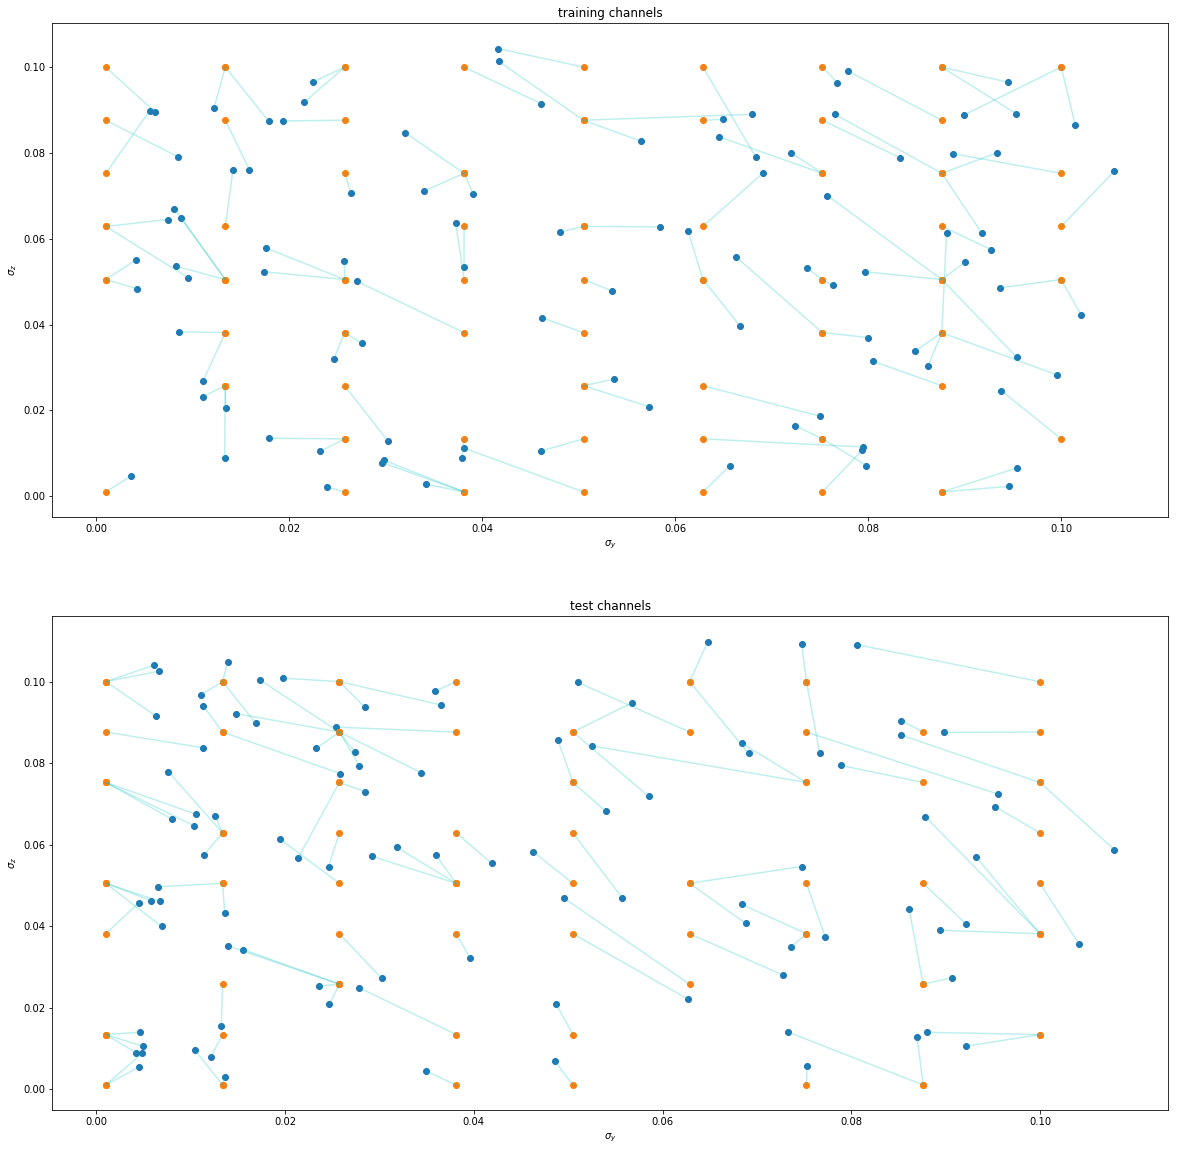

In [46]:
from sklearn.utils.random import sample_without_replacement
%matplotlib inline

plt.rcParams["figure.figsize"] = (20, 20)
plt.figure()

plt.subplot(2, 1, 1)

plt.title("training channels")

idx = sample_without_replacement(len(tr_preds), 100)

for i in idx:
    plt.plot((tr_preds[:, 1][i], lt_train[:, 1][i]), (tr_preds[:, 2][i], lt_train[:, 2][i]), c='c', alpha=0.25)
    
plt.scatter(tr_preds[:, 1][idx], tr_preds[:, 2][idx])
plt.scatter(lt_train[:, 1][idx], lt_train[:, 2][idx])

plt.xlabel(r"$\sigma_y$")
plt.ylabel(r"$\sigma_z$")

plt.subplot(2, 1, 2)

plt.title("test channels")

idx = sample_without_replacement(len(ts_preds), 100)

for i in idx:
    plt.plot((ts_preds[:, 1][i], lt_test[:, 1][i]), (ts_preds[:, 2][i], lt_test[:, 2][i]), c='c', alpha=0.25)
    
plt.scatter(ts_preds[:, 1][idx], ts_preds[:, 2][idx])
plt.scatter(lt_test[:, 1][idx], lt_test[:, 2][idx])

plt.xlabel(r"$\sigma_y$")
plt.ylabel(r"$\sigma_z$")

plt.show()

## NN Ranking

In [19]:
print("train preds: ", tr_preds)

print("target train: ", lt_train)

print("test preds: ", ts_preds)

print("target test: ", lt_test)

train preds:  [[0.00439447 0.0067897  0.0074344  0.9813814 ]
 [0.08528258 0.04683617 0.01462097 0.85326016]
 [0.03680463 0.10122579 0.05975438 0.80221516]
 ...
 [0.03533896 0.04529959 0.08946266 0.82989883]
 [0.01584443 0.06835113 0.05383629 0.86196816]
 [0.09026971 0.07695186 0.09012321 0.74265516]]
target train:  [[0.001    0.001    0.013375 0.984625]
 [0.1      0.038125 0.02575  0.836125]
 [0.038125 0.087625 0.062875 0.811375]
 ...
 [0.038125 0.0505   0.1      0.811375]
 [0.013375 0.062875 0.062875 0.860875]
 [0.1      0.07525  0.087625 0.737125]]
test preds:  [[0.005027   0.00691203 0.03990552 0.9481555 ]
 [0.0688794  0.00308796 0.05524605 0.8727865 ]
 [0.03174629 0.09456099 0.06811289 0.8055798 ]
 ...
 [0.08170623 0.07954556 0.04051616 0.7982321 ]
 [0.06753942 0.07188698 0.0129952  0.8475784 ]
 [0.058712   0.07868137 0.08667868 0.775928  ]]
target test:  [[0.001    0.001    0.0505   0.9475  ]
 [0.07525  0.001    0.038125 0.885625]
 [0.02575  0.1      0.07525  0.799   ]
 ...
 [0.08

In [29]:
corr = 0
dup = 0

for i in range(len(tr_preds)):
    tr = tr_preds[i]
    lbl = lt_train[i]
    
    if lbl[0] == lbl[1] or lbl[0] == lbl[2] or lbl[1] == lbl[2]:
        dup += 1
        continue
    
    a0 = tr[0] > tr[1]
    a1 = tr[1] > tr[2]
    a2 = tr[0] > tr[2]
    
    b0 = lbl[0] > lbl[1]
    b1 = lbl[1] > lbl[2]
    b2 = lbl[0] > lbl[2]
    
    if a0 == b0 and a1 == b1 and a2 == b2:
        corr += 1
    
print("training ordering accuracy: ", corr / (len(tr_preds) - dup))

training ordering accuracy:  0.8768962944541159


tensor([[0.0050, 0.0069, 0.0399, 0.9482],
        [0.0689, 0.0031, 0.0552, 0.8728],
        [0.0317, 0.0946, 0.0681, 0.8056],
        ...,
        [0.0817, 0.0795, 0.0405, 0.7982],
        [0.0675, 0.0719, 0.0130, 0.8476],
        [0.0587, 0.0787, 0.0867, 0.7759]], requires_grad=True)


In [8]:
corr = 0
dup = 0

for i in range(len(ts_preds)):
    tr = ts_preds[i]
    lbl = lt_test[i]
    
    if np.abs(lbl[0] - lbl[1]) < 0.015 or np.abs(lbl[0] - lbl[2]) < 0.015 or np.abs(lbl[1] - lbl[2]) < 0.015:
        dup += 1
        continue
    
    a0 = tr[0] > tr[1]
    a1 = tr[1] > tr[2]
    a2 = tr[0] > tr[2]
    
    b0 = lbl[0] > lbl[1]
    b1 = lbl[1] > lbl[2]
    b2 = lbl[0] > lbl[2]
    
    if a0 == b0 and a1 == b1 and a2 == b2:
        corr += 1
    
print("test ordering accuracy: ", corr / (len(ts_preds) - dup))
print("random guessing: ", 1/6)

test ordering accuracy:  0.9191176470588235
random guessing:  0.16666666666666666


- move away from L=1 germs
- small differences are "equal" (10% magnitude)
- prepare x,y,z eigenstates is simple strategy: ~2500 * 3 measurements
- distinguish unitarity changing in time